In [115]:
# import essential libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import joblib

In [116]:
# import library for normalizing, modeling, evaluate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Prep

In [117]:
#Reading training and testing data as dataframes
full = pd.read_csv("Transaction.csv",sep =",")
account = pd.read_csv("Account.csv",sep =",")
product = pd.read_csv("Product.csv",sep =",")

In [118]:
full.describe()

,transaction_id,Account_id,transaction_amount,gas_price_purchase,product_id,Location
count,44500.000000,44500.000000,44500.000000,44500.000000,44500.000000,44500.0
mean,22250.500000,1698.967326,26.459262,24.931345,6.666157,7.0
std,12846.187826,543.420426,28.004480,27.375839,3.198977,0.0
min,1.000000,1001.000000,0.000000,0.000000,1.000000,7.0
25%,11125.750000,1251.000000,3.000000,0.000000,4.000000,7.0
50%,22250.500000,1512.000000,3.500000,0.000000,7.000000,7.0
75%,33375.250000,2096.000000,49.260000,49.320000,10.000000,7.0
max,44500.000000,3000.000000,881.090000,89.370000,10.000000,7.0


In [119]:
account

,Account_id,Age,Register Date,Unnamed: 3
0,1001,31.0,NaN,
1,1002,29.0,NaN,
2,1003,54.0,NaN,
3,1004,28.0,NaN,
4,1005,64.0,'2022-10-02',
...,...,...,...,...
1995,2996,NaN,NaN,NaN
1996,2997,NaN,NaN,NaN
1997,2998,NaN,NaN,NaN
1998,2999,NaN,NaN,NaN


In [120]:
account.drop(['Register Date','Unnamed: 3'],axis=1, inplace=True)
account.head()

,Account_id,Age
0,1001,31.0
1,1002,29.0
2,1003,54.0
3,1004,28.0
4,1005,64.0


In [121]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Account_id  2000 non-null   int64  
 1   Age         1373 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [122]:
avg_age = account['Age'].mean()
avg_age

40.86161689730517

In [123]:
account = account.fillna(avg_age)

In [124]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Account_id  2000 non-null   int64  
 1   Age         2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [125]:
account.set_index('Account_id')

,Age
Account_id,
1001,31.000000
1002,29.000000
1003,54.000000
1004,28.000000
1005,64.000000
...,...
2996,40.861617
2997,40.861617
2998,40.861617


In [126]:
account_dict = dict()
for i in range(len(account)):
    account_dict[account['Account_id'][i]] = account['Age'][i]

In [127]:
full.head()

,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7


In [128]:
# fill in new column
full.insert(0,'age',0)
full.insert(0,'product_price',0)
full.insert(0,'product_cat',0)
full.insert(0,'time',0)
full.insert(0,'day',0)
full.insert(0,'month',0)

l_product_cat = [0,1,0,1,1,0,0,0,0,0]
l_product_price = [2.5,3,2,3.5,3,3.5,3.5,2.5,3,4]

for i in range(len(full)):
    full['age'][i] = account_dict[full['Account_id'][i]]
    full["product_price"][i] = l_product_price[full["product_id"][i]-1]
    full["product_cat"][i] = l_product_cat[full["product_id"][i]-1]
    hour, minute = full['time_to_purchase'][i].split(':')
    full['time'][i] = int(hour)*60 + int(minute)
    month, day, year = full['transaction_date'][i].split('/')
    full['day'][i] = int(day)
    full['month'][i] = int(month)

C:\Users\user\AppData\Local\Temp\ipykernel_26180\2444927080.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full['age'][i] = account_dict[full['Account_id'][i]]
C:\Users\user\AppData\Local\Temp\ipykernel_26180\2444927080.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full["product_price"][i] = l_product_price[full["product_id"][i]-1]
C:\Users\user\AppData\Local\Temp\ipykernel_26180\2444927080.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [129]:
full

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,1,1,660,0,3.5,49.000000,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [130]:
full_copy = pd.DataFrame(full)
full_copy

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,1,1,660,0,3.5,49.000000,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [131]:
# eliminate errors
index_list = []
for i in range(len(full)):
    if abs(full['transaction_amount'][i] -full['product_price'][i] - full['gas_price_purchase'][i]) > 0.009 and full['product_id'][i] != 10:
        index_list.append(i)

len(index_list)

6068

In [132]:
full = full.drop(index=index_list)

In [133]:
full

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
5,1,1,900,1,3.5,23.000000,2170,1016,3.50,1/1/2023,15:00,NaN,0.00,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [134]:
# explore variable
for col in full.columns.values:
    print(f"{20 * '-'}\n{col} \n{20 * '-'}")
    print(full[col].value_counts(), '\n')

--------------------
month 
--------------------
1    10056
3     9924
4     9557
2     8895
Name: month, dtype: int64 

--------------------
day 
--------------------
24    1343
16    1340
27    1331
9     1329
12    1317
17    1309
28    1308
5     1305
8     1303
23    1302
21    1300
11    1295
19    1294
10    1293
2     1275
22    1268
26    1260
7     1259
13    1257
15    1257
1     1255
18    1253
20    1245
25    1244
6     1234
14    1231
4     1228
3     1201
29     999
30     935
31     662
Name: day, dtype: int64 

--------------------
time 
--------------------
360     3768
420     3699
480     3628
1140    3367
1200    2675
1080    2262
840     1739
720     1727
540     1721
660     1707
600     1702
780     1687
960     1669
900     1647
1020    1632
1320    1571
1380    1273
1110     626
1260     332
Name: time, dtype: int64 

--------------------
product_cat 
--------------------
0    30756
1     7676
Name: product_cat, dtype: int64 

--------------------
product_pri

In [135]:
# drop unrelated columns
# transaction_id: unrelated
# transaction_date: unrelated + unable to transform into numbers
# gas_type: unrelated + a lot of NaN
# Location: all 7
# time_to_purchase: replaced with the numerical time column
full.drop(['transaction_id','transaction_date','gas_type','Location','time_to_purchase'],axis=1, inplace=True)

In [136]:
full.head()

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
0,1,1,1140,0,2.5,28.0,1004,2.5,0.0,1
2,1,1,720,0,4.0,19.0,1014,37.8,37.8,10
3,1,1,900,1,3.0,39.0,1015,3.0,0.0,2
4,1,1,960,1,3.0,23.0,1016,3.0,0.0,2
5,1,1,900,1,3.5,23.0,1016,3.5,0.0,4


# Description

time: time in minutes from 0 (00:00) to 1499 (23:59)

product_cat: integer coded boolean (0 or 1) 0 for beverage 1 for pastry

product_price: price of product

age: the age of a customer, if none was recorded ana verage value is filled in 40.861617

Account_id: the account id (included as teh same person might order the same thing)

transaction_amount: total money spent

gas_price_purchase: the gas price (included just in case rich people buy different compared to poor)

product_id: categorical id of the product included instead of name

In [137]:
full.isnull().sum()

month                 0
day                   0
time                  0
product_cat           0
product_price         0
age                   0
Account_id            0
transaction_amount    0
gas_price_purchase    0
product_id            0
dtype: int64

In [138]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 44499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               38432 non-null  int64  
 1   day                 38432 non-null  int64  
 2   time                38432 non-null  int64  
 3   product_cat         38432 non-null  int64  
 4   product_price       38432 non-null  float64
 5   age                 38432 non-null  float64
 6   Account_id          38432 non-null  int64  
 7   transaction_amount  38432 non-null  float64
 8   gas_price_purchase  38432 non-null  float64
 9   product_id          38432 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 3.2 MB


In [139]:
print("full", full.duplicated().sum())
# nothing to worry about, it is just the same customer ordering the same thing twice
# with the transcation_id this disappear

full 8


In [140]:
full.describe()

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
count,38432.000000,38432.000000,38432.000000,38432.000000,38432.000000,38432.000000,38432.000000,38432.000000,38432.000000,38432.000000
mean,2.493911,15.610091,804.873022,0.199729,3.384914,41.105917,1769.682999,22.751139,20.958046,7.017147
std,1.127234,8.684538,321.923973,0.399802,0.648725,12.587222,549.536918,27.697929,26.703061,3.178781
min,1.000000,1.000000,360.000000,0.000000,2.000000,7.000000,1001.000000,0.000000,0.000000,1.000000
25%,1.000000,8.000000,480.000000,0.000000,3.000000,32.000000,1299.000000,3.000000,0.000000,4.000000
50%,3.000000,16.000000,780.000000,0.000000,3.500000,40.861617,1661.000000,3.500000,0.000000,8.000000
75%,3.000000,23.000000,1110.000000,0.000000,4.000000,51.000000,2205.000000,44.630000,44.700000,10.000000
max,4.000000,31.000000,1380.000000,1.000000,4.000000,89.000000,3000.000000,881.090000,89.370000,10.000000


In [141]:
full

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
0,1,1,1140,0,2.5,28.000000,1004,2.50,0.00,1
2,1,1,720,0,4.0,19.000000,1014,37.80,37.80,10
3,1,1,900,1,3.0,39.000000,1015,3.00,0.00,2
4,1,1,960,1,3.0,23.000000,1016,3.00,0.00,2
5,1,1,900,1,3.5,23.000000,1016,3.50,0.00,4
...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,2933,3.50,0.00,6
44496,4,30,1380,0,4.0,40.861617,2936,61.02,61.02,10
44497,4,30,1320,1,3.5,40.861617,2957,3.50,0.00,4
44498,4,30,1320,0,4.0,40.861617,2978,32.69,32.69,10


# **EDA**

### There are two data types:

**Numerical Data:** 
- product_price: price of product
- transaction_amount: total money spent
- gas_price_purchase: the gas price (included just in case rich people buy different compared to poor)
- age: the age of a customer, if none was recorded an average value is filled in 40.861617

**Categorical Data:**
- Account_id: the account id (included as teh same person might order the same thing)
- product_cat: integer coded boolean (0 or 1) 0 for beverage 1 for pastry
- product_id: categorical id of the product included instead of name

# Univariate Analysis

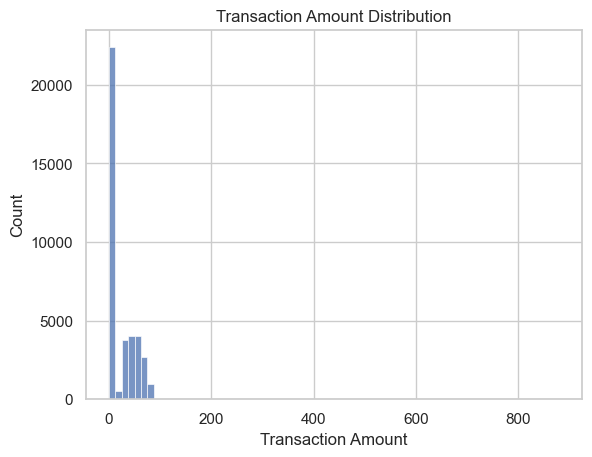

In [142]:
sns.histplot(data= full, x='transaction_amount', bins=70, edgecolor='white')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')

plt.show()

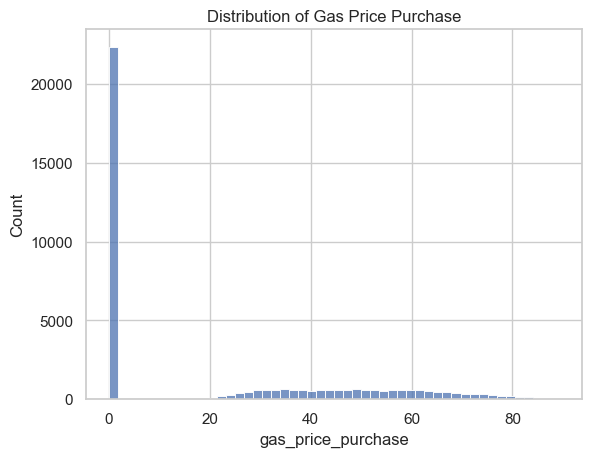

In [143]:
sns.histplot(data=full, x='gas_price_purchase', bins=50, edgecolor='white')
plt.title('Distribution of Gas Price Purchase')
plt.show()

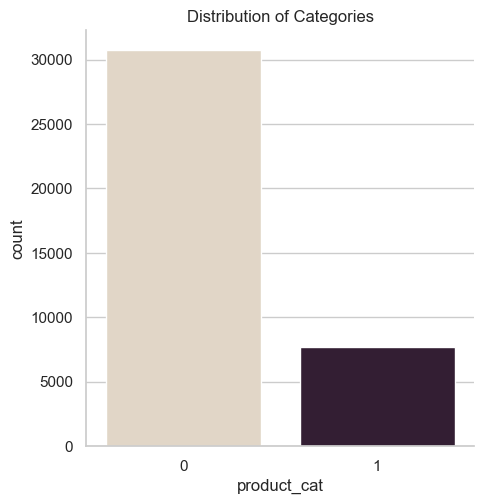

In [144]:
sns.catplot(data=full, x= 'product_cat', kind="count", palette="ch:.25")
plt.title('Distribution of Categories')
plt.show()
# beverage > pastry

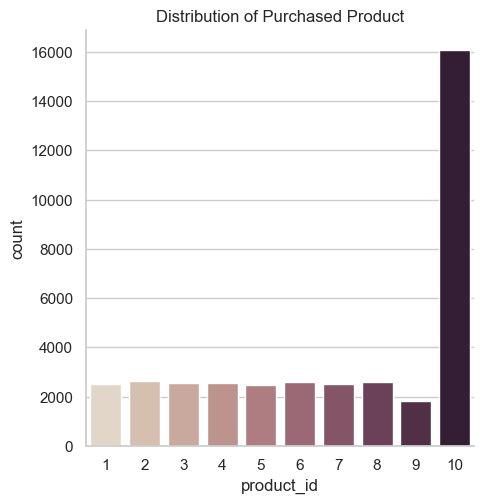

In [145]:
sns.catplot(data=full, x= 'product_id', kind="count", palette="ch:.25")
plt.title('Distribution of Purchased Product')
plt.show()

# 10 = redbull (highest) , 9 = hot chocolate (lowest)

# Bivariate Analysis

In [146]:
def plot_categorical_variable(data, name, figsize=(8,4), rotation=45):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data, hue='product_id')
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data)
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

*Numerical Data  bar charts*



C:\Users\user\AppData\Local\Temp\ipykernel_26180\1088531251.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_products = merged.groupby(['product_id', 'product_name']).sum().sort_values(by='transaction_amount', ascending=False).head(10)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'RedBull'),
  Text(1, 0, 'Latte'),
  Text(2, 0, 'Muffin'),
  Text(3, 0, 'Cappuccino'),
  Text(4, 0, 'Croissant'),
  Text(5, 0, 'Bagel'),
  Text(6, 0, 'Espresso'),
  Text(7, 0, 'Coffee'),
  Text(8, 0, 'Hot Chocolate'),
  Text(9, 0, 'Tea')])

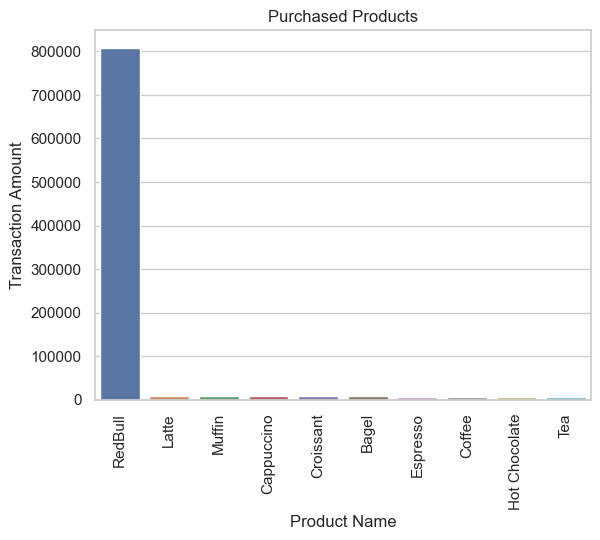

In [147]:
# transaction & purchased product barplot
merged = pd.merge(full, product, on='product_id')
top_products = merged.groupby(['product_id', 'product_name']).sum().sort_values(by='transaction_amount', ascending=False).head(10)
sns.barplot(data=top_products, x=top_products.index.get_level_values('product_name'), y='transaction_amount')
plt.title('Purchased Products')
plt.xlabel('Product Name')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=90)

In [148]:
def get_age_group(age):
    if age < 10:
        return '0s'
    elif age < 20:
        return '10s'
    elif age < 30:
        return '20s'
    elif age < 40:
        return '30s'
    elif age < 50:
        return '40s'
    elif age < 60:
        return '50s'
    elif age < 70:
        return '60s'
    elif age < 80:
        return '70s'
    elif age < 90:
        return '80s'
    else:
        return '90+'

full['age_group'] = full['age'].apply(get_age_group)

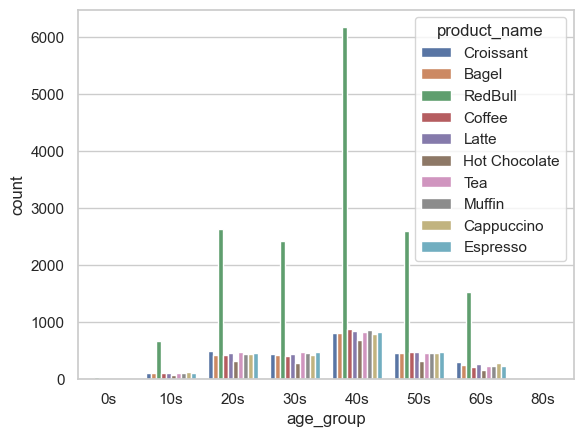

In [149]:
#age group & purchased product

merged_data = full.merge(product, on='product_id', how='left')
merged_data_sorted = merged_data.sort_values('age_group')
sns.set_theme(style="whitegrid")
sns.countplot(x='age_group', data= merged_data_sorted, hue='product_name')
plt.show()

# 40s redbull >>>>

Merged Dataset Summary:
       month  day  time  product_cat  product_price_x        age  Account_id  \
19215      3    1   360            0              4.0  40.861617        2634   
20691      3    6   360            0              3.0  41.000000        2050   
26394      3   24   360            0              4.0  44.000000        1478   
15172      2   17   360            0              2.5  31.000000        1099   
15173      2   17   360            0              4.0  62.000000        1102   

       transaction_amount  gas_price_purchase  product_id age_group  \
19215               29.96               29.96          10       40s   
20691                3.00                0.00           9       40s   
26394               48.72               48.72          10       40s   
15172                2.50                0.00           1       30s   
15173               81.00               81.00          10       60s   

        product_name   product_description product_category  product

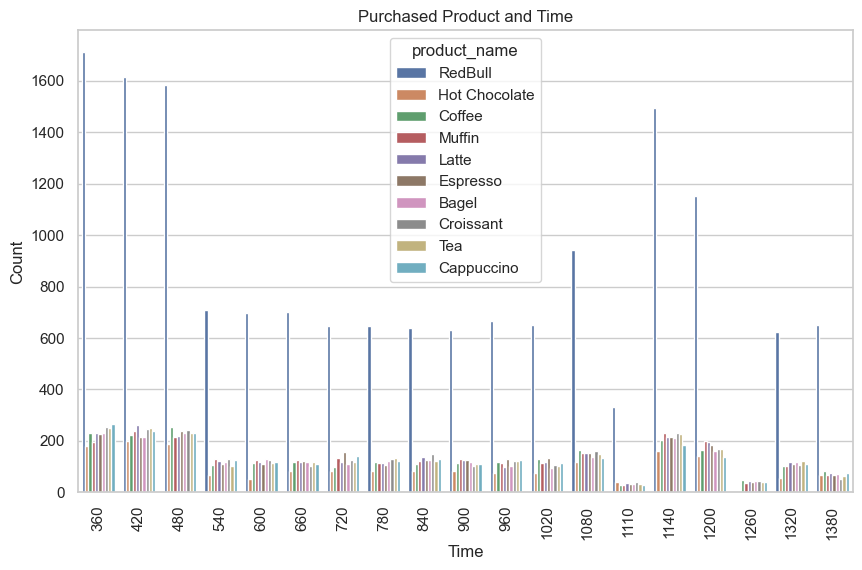

In [150]:
# time & product

# Perform the join operation
merged_data = full.merge(product, on='product_id', how='left')

# Sort the DataFrame by time
merged_data_sorted = merged_data.sort_values('time')

# Perform basic EDA
print("Merged Dataset Summary:")
print(merged_data_sorted.head())  # Display the first few rows of the sorted merged dataset
print(merged_data_sorted.info())  # Overview of the sorted merged dataset's structure

# Count plot of time_to_purchase and product_name
plt.figure(figsize=(10, 6))
sns.countplot(x='time', hue='product_name', data=merged_data_sorted)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Purchased Product and Time')
plt.xticks(rotation=90)
plt.show()

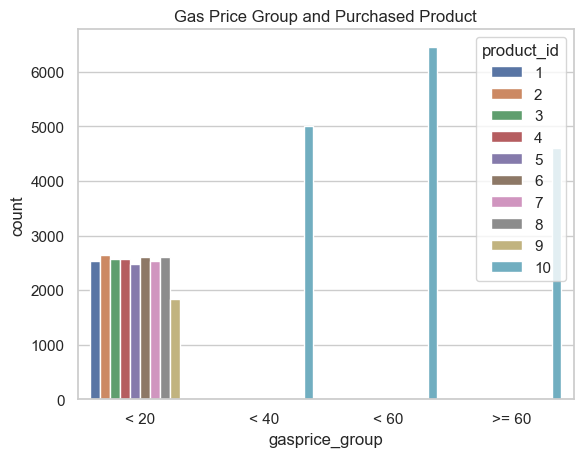

In [151]:
#gas price and product

new_col = 'gasprice_group'
full[new_col] = ''
for index, row in full.iterrows():
    r = row['gas_price_purchase'] 
    if r < 20:
        full.at[index, new_col] = '< 20'
    elif r < 40:
        full.at[index, new_col] = '< 40'
    elif r < 60:
        full.at[index, new_col] = '< 60'
    else:
        full.at[index, new_col] = '>= 60'   

sns.set_theme(style="whitegrid")
sns.countplot(x=full['gasprice_group'], data=full, hue='product_id')
plt.title('Gas Price Group and Purchased Product')
plt.show()

# if dont buy gas -> likely to dont buy redbull

In [152]:
new_col = 'category'
full[new_col] = ''
for index, row in full.iterrows():
    r = row['product_cat'] 
    if r == 0:
        full.at[index, new_col] = 'Beverage'
   
    else:
        full.at[index, new_col] = 'Pastry'   

In [153]:
def plot_categorical_variable(data, name, figsize=(8,4), rotation=45):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data, hue='category')
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data)
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

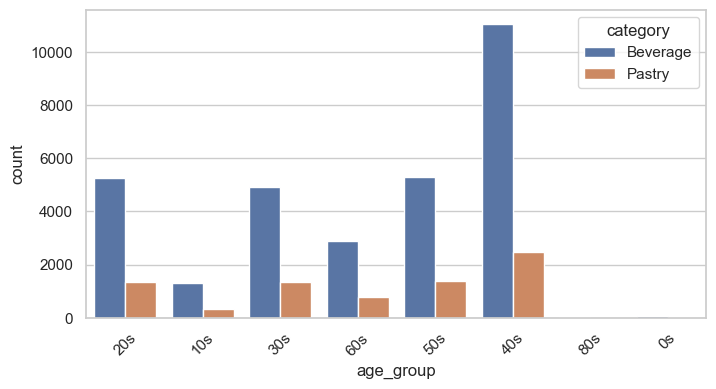

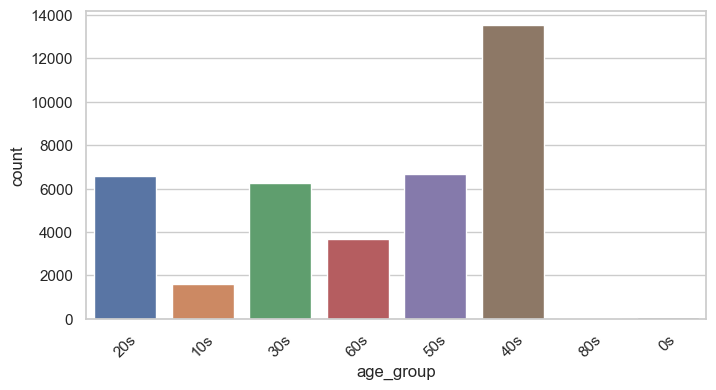

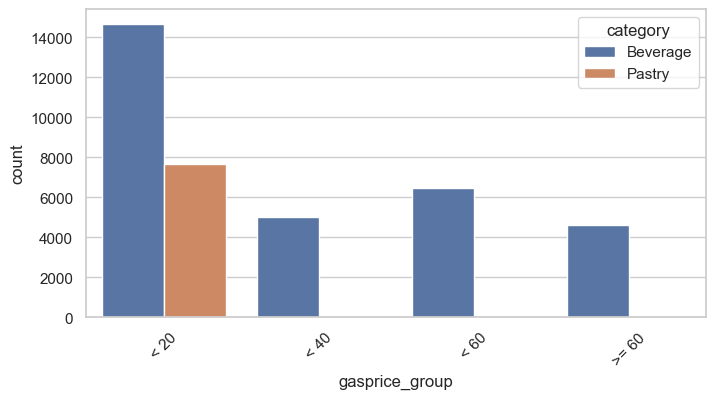

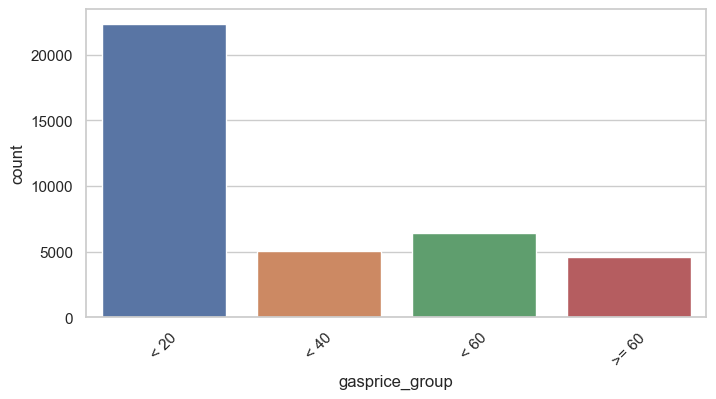

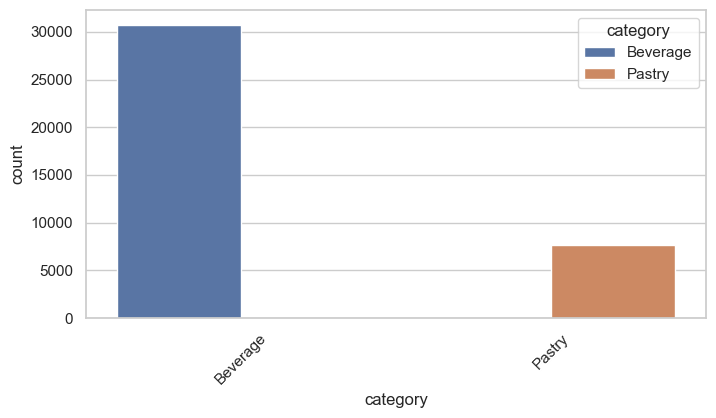

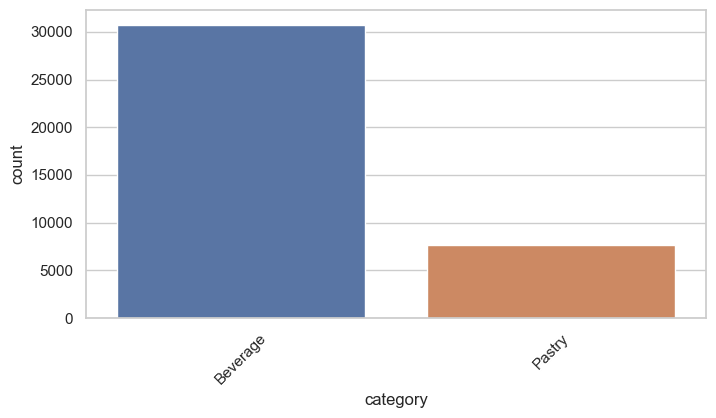

In [154]:
# data visualization for categorical columns

categorical = full.select_dtypes(include=['object']).columns.values

for col in categorical:
    plot_categorical_variable(full, col)

In [155]:
# drop the columns we built to plot the histogram

full.drop(['age_group', 'gasprice_group', 'category'], axis=1, inplace=True)

<AxesSubplot: >

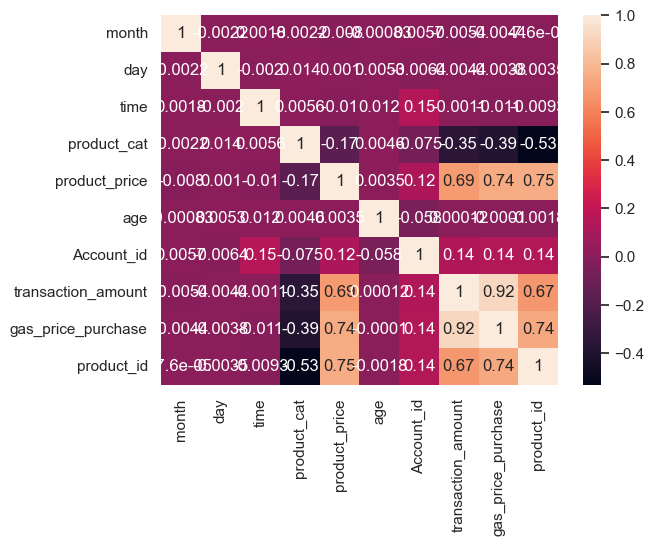

In [156]:
correlation_matrix = full.corr()
sns.heatmap(correlation_matrix, annot =True)

In [157]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_26180\102845399.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


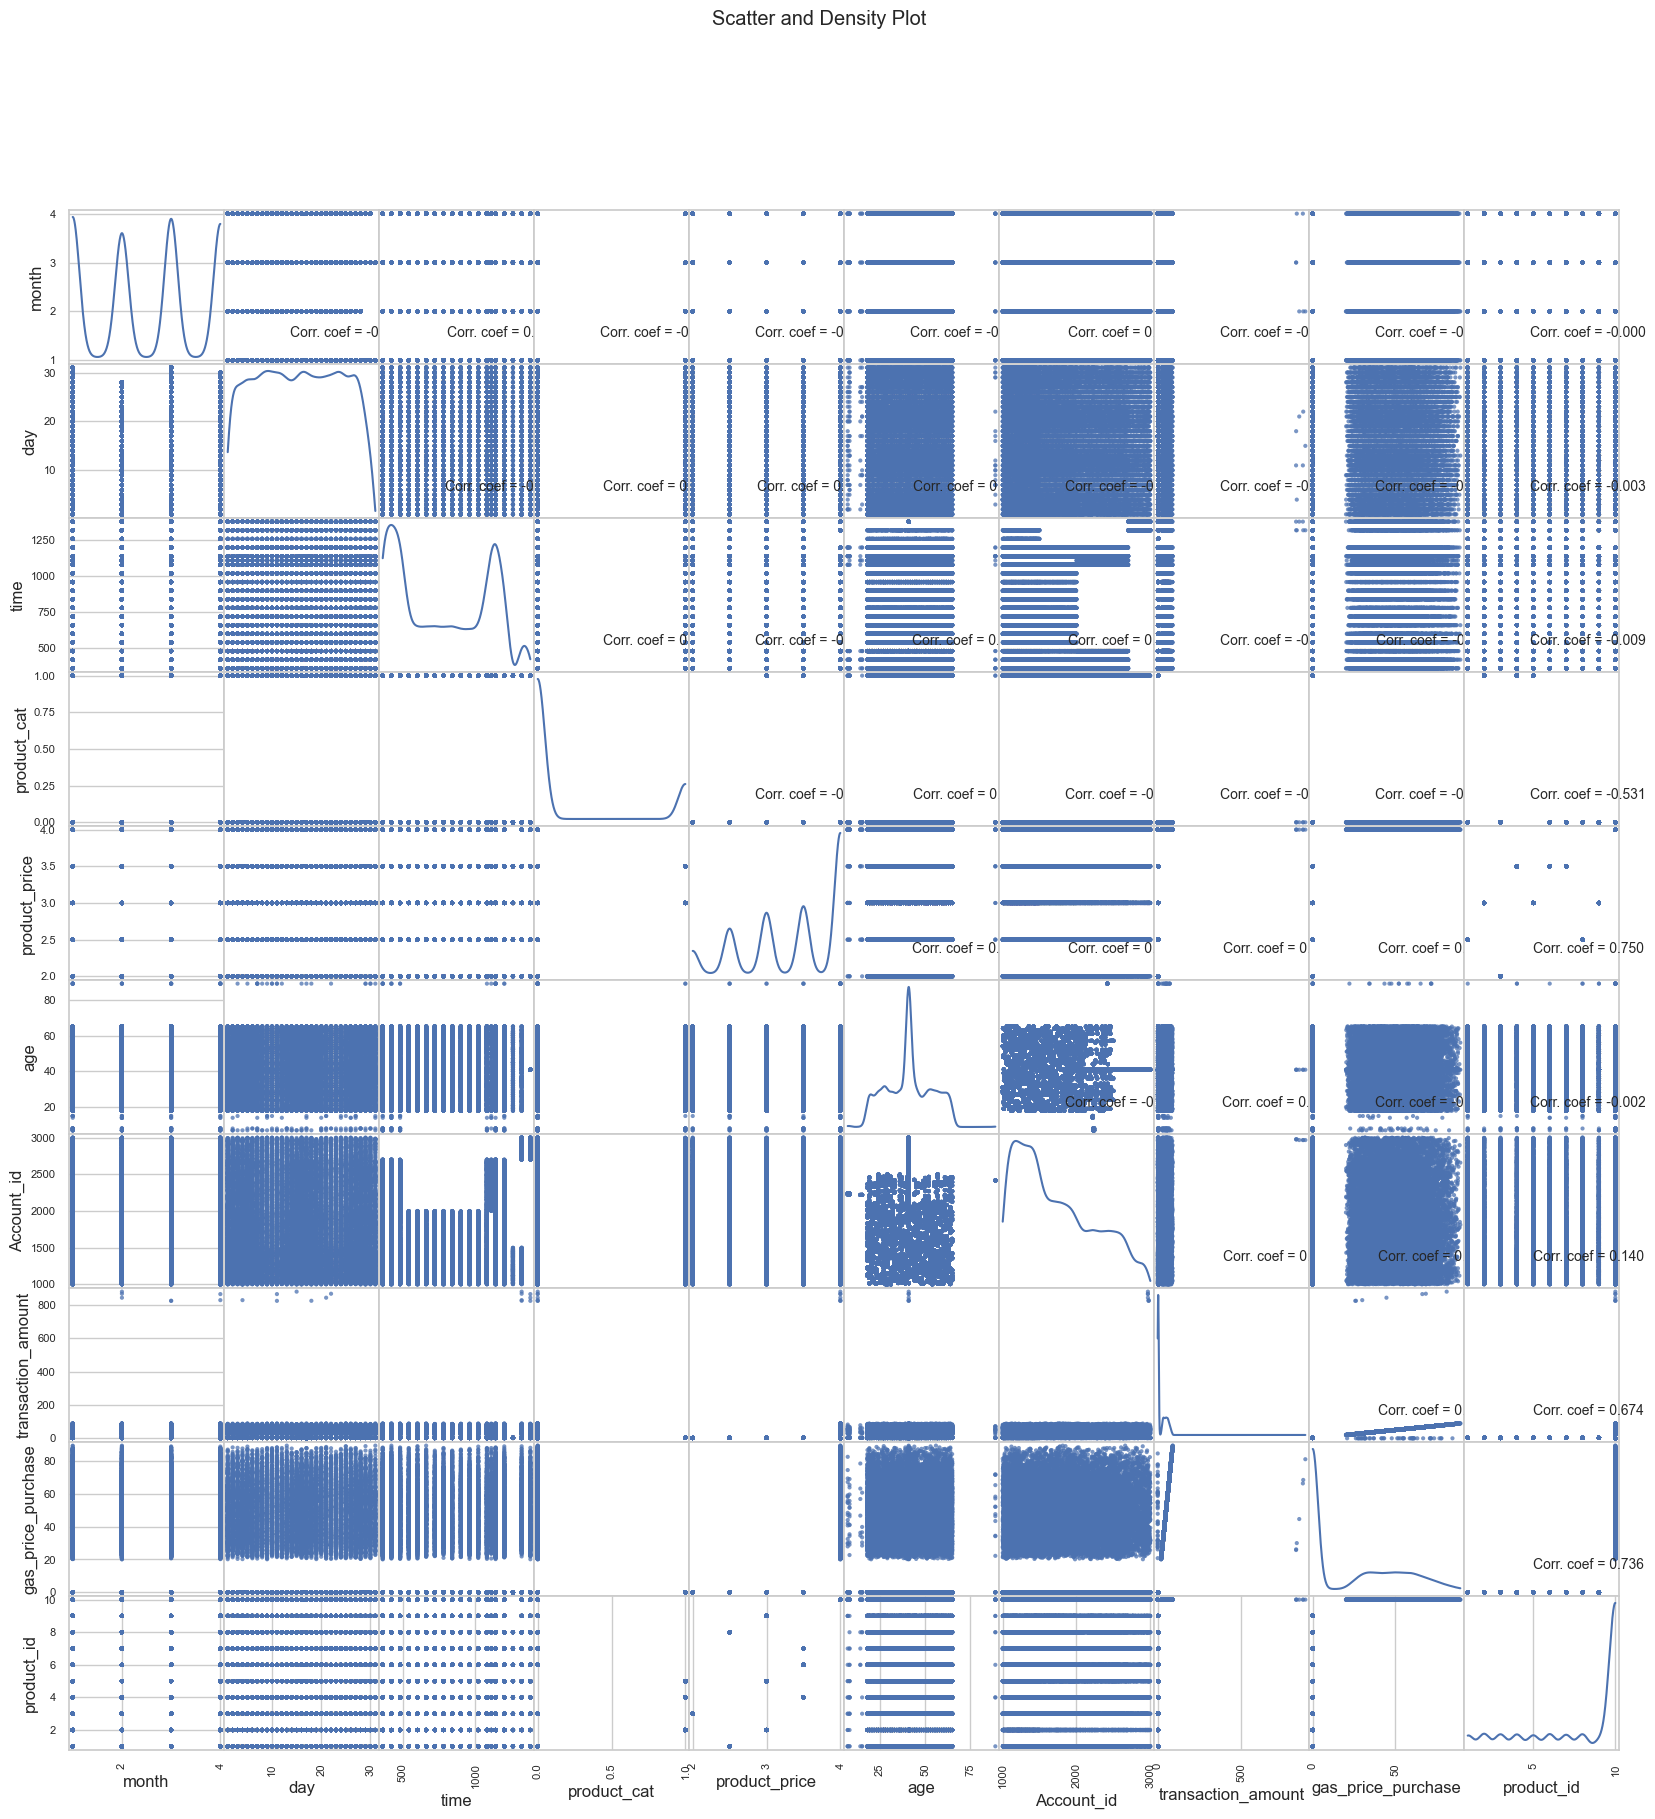

In [158]:
plotScatterMatrix(full, 20, 10)

In [159]:
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores
df1 = full.iloc[:,:-1]
vif_scores(df1)

,Independent Features,VIF Scores
0,month,5.534745
1,day,4.070612
2,time,7.044101
3,product_cat,1.537030
4,product_price,29.072869
5,age,10.112651
6,Account_id,10.830639
7,transaction_amount,10.681635
8,gas_price_purchase,11.847488


**Many of the colums in the data are highly multi-collinear**

**Fortunately, we will be using non-linear classification models which do not have much problems with multi-collinearlity**

In [160]:
# full.drop(['transaction_amount','product_cat', 'product_price'], axis=1, inplace=True)

In [161]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 44499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               38432 non-null  int64  
 1   day                 38432 non-null  int64  
 2   time                38432 non-null  int64  
 3   product_cat         38432 non-null  int64  
 4   product_price       38432 non-null  float64
 5   age                 38432 non-null  float64
 6   Account_id          38432 non-null  int64  
 7   transaction_amount  38432 non-null  float64
 8   gas_price_purchase  38432 non-null  float64
 9   product_id          38432 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 4.2 MB


In [162]:
df1 = full.iloc[:,:-1]
vif_scores(df1)

,Independent Features,VIF Scores
0,month,5.534745
1,day,4.070612
2,time,7.044101
3,product_cat,1.537030
4,product_price,29.072869
5,age,10.112651
6,Account_id,10.830639
7,transaction_amount,10.681635
8,gas_price_purchase,11.847488


# ML

In [163]:
train, test = train_test_split(full,train_size=0.8,test_size=0.2)
train.info()
print()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30745 entries, 23365 to 37281
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               30745 non-null  int64  
 1   day                 30745 non-null  int64  
 2   time                30745 non-null  int64  
 3   product_cat         30745 non-null  int64  
 4   product_price       30745 non-null  float64
 5   age                 30745 non-null  float64
 6   Account_id          30745 non-null  int64  
 7   transaction_amount  30745 non-null  float64
 8   gas_price_purchase  30745 non-null  float64
 9   product_id          30745 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 2.6 MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7687 entries, 18819 to 24918
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               7687 non-null

In [164]:
train

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
23365,3,5,660,1,3.0,41.000000,1147,3.00,0.00,2
33767,4,1,1380,0,4.0,40.861617,2895,60.03,60.03,10
33855,4,2,840,1,3.0,33.000000,1219,3.00,0.00,2
4711,1,13,360,0,4.0,31.000000,1758,74.28,74.28,10
43614,4,28,420,0,4.0,31.000000,1731,29.72,29.72,10
...,...,...,...,...,...,...,...,...,...,...
24981,3,9,1200,0,4.0,18.000000,1702,55.60,55.60,10
11340,1,31,720,0,2.5,43.000000,1281,2.50,0.00,8
38475,4,14,480,0,2.5,41.000000,2186,2.50,0.00,1
37921,4,13,720,1,3.0,60.000000,1310,3.00,0.00,5


In [165]:
test

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
18819,2,20,360,0,3.5,21.0,1853,3.50,0.00,7
40678,4,20,900,0,3.5,44.0,1897,3.50,0.00,6
13285,2,5,960,0,4.0,39.0,1522,59.64,59.64,10
5031,1,14,1020,0,3.0,61.0,1495,3.00,0.00,9
2441,1,7,1080,0,4.0,36.0,1948,35.72,35.72,10
...,...,...,...,...,...,...,...,...,...,...
36863,4,10,1080,0,4.0,65.0,1421,30.90,30.90,10
28318,3,18,1080,0,4.0,54.0,1579,35.85,35.85,10
1457,1,5,720,0,3.5,34.0,1054,3.50,0.00,6
37618,4,12,600,0,4.0,60.0,1546,26.73,26.73,10


In [166]:
cols = ['month', 'day','time', 'age', 'Account_id', 'gas_price_purchase']

X_train = pd.DataFrame(train[cols])
X_test = pd.DataFrame(test[cols])

Y_train = train['product_id']
Y_test = test['product_id']


X_train.columns = cols
X_test.columns = cols

In [167]:
X_train

,month,day,time,age,Account_id,gas_price_purchase
23365,3,5,660,41.000000,1147,0.00
33767,4,1,1380,40.861617,2895,60.03
33855,4,2,840,33.000000,1219,0.00
4711,1,13,360,31.000000,1758,74.28
43614,4,28,420,31.000000,1731,29.72
...,...,...,...,...,...,...
24981,3,9,1200,18.000000,1702,55.60
11340,1,31,720,43.000000,1281,0.00
38475,4,14,480,41.000000,2186,0.00
37921,4,13,720,60.000000,1310,0.00


In [168]:
X_test

,month,day,time,age,Account_id,gas_price_purchase
18819,2,20,360,21.0,1853,0.00
40678,4,20,900,44.0,1897,0.00
13285,2,5,960,39.0,1522,59.64
5031,1,14,1020,61.0,1495,0.00
2441,1,7,1080,36.0,1948,35.72
...,...,...,...,...,...,...
36863,4,10,1080,65.0,1421,30.90
28318,3,18,1080,54.0,1579,35.85
1457,1,5,720,34.0,1054,0.00
37618,4,12,600,60.0,1546,26.73


In [169]:
Y_train

23365     2
33767    10
33855     2
4711     10
43614    10
         ..
24981    10
11340     8
38475     1
37921     5
37281    10
Name: product_id, Length: 30745, dtype: int64

In [170]:
Y_test

18819     7
40678     6
13285    10
5031      9
2441     10
         ..
36863    10
28318    10
1457      6
37618    10
24918    10
Name: product_id, Length: 7687, dtype: int64

In [171]:
# catboost
import catboost
model_cb = catboost.CatBoostClassifier(logging_level='Silent')
model_cb.fit(X_train, Y_train)

Y_catboost = model_cb.predict(X_test)

metrics.accuracy_score(Y_test, Y_catboost)

0.4910888513074021

In [172]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(X_train, Y_train)
y_lgbm = lgbm.predict(X_test)

In [173]:
metrics.accuracy_score(Y_test, y_lgbm)

0.4880967867828802

# Evaluating

In [178]:
col_names = cols
col_names

['month', 'day', 'time', 'age', 'Account_id', 'gas_price_purchase']

In [179]:
importance_table = pd.DataFrame({'Features':col_names, 'Importances':model_cb.feature_importances_})
display(importance_table)

,Features,Importances
0,month,8.511094
1,day,9.924241
2,time,8.970206
3,age,9.090639
4,Account_id,9.816566
5,gas_price_purchase,53.687255


**Check with test dataset to see the feature importance**

In [191]:
# train a new model this time using the testing set, we scale the iterations down to 200
model_cb_test = catboost.CatBoostClassifier(logging_level='Silent')
model_cb_test.fit(X_test, Y_test)

In [192]:
importance_table = pd.DataFrame({'Features':col_names, 'Importances': model_cb_test.feature_importances_})
importance_table

,Features,Importances
0,month,13.526660
1,day,16.159613
2,time,14.609681
3,age,14.296351
4,Account_id,14.479723
5,gas_price_purchase,26.927973


Although the gas_price_purchase is considerably higher in importance compare to the other features in both cases, they are drastically different in value.

Furthermore, the high accuracy could have just come from outputting any input with non zero gas price purchase as redbull

This means our model although works, is not exactly reliable

**Better models**

In [ ]:
new_cols = ['month', 'day','time', 'age', 'Account_id', 'gas_price_purchase', 'product_id', 'product_cat']

X_train = pd.DataFrame(train[cols])
X_test = pd.DataFrame(test[cols])

Y_train = train['product_id']
Y_test = test['product_id']


X_train.columns = cols
X_test.columns = cols

# Non ML methods

**It is possible that the ML method may not be the best way to recommend**

In [183]:
full_copy

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,1,1,660,0,3.5,49.000000,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [184]:
full_copy['product_id'].value_counts()

10    16087
2      3447
8      3348
3      3336
1      3317
6      3309
4      3299
7      3296
5      3225
9      1836
Name: product_id, dtype: int64

**1. Previously Ordered**

idea: people are likely to be buying things that they had already purchase before

In [185]:
def get_history(id):
    return full_copy.loc[full_copy['Account_id'] == id]

def get_value_count(id):
    return get_history(id)['product_id'].value_counts()

def get_top(id, n=3, threshold = 3, threshold_ratio = 0, get_all=False):
    product_history = get_history(id)
    tot = len(product_history)
    v = product_history['product_id'].value_counts()
    v_count = len(v)
    if get_all:
        threshold=0
        threshold_ratio=0
        n = v_count
    l = list(v.items())
    ans = []
    for i in range(min(n, v_count)):
        if l[i][1] >= threshold and l[i][1]/tot >= threshold_ratio:
            ans.append(l[i][0])
    return ans, tot

# get top function can be used to get the top n purchased product ID and the total number of transaction,
# which has the occurence beyond threshold and ratio over threshold_ratio
# for example: let us find the top 3 of an ID 1004 witrh different parameters
print(get_top(1004))
print(get_top(1004, get_all=True))

([10, 4, 3], 40)
([10, 4, 3, 7, 5, 1, 6, 9, 2, 8], 40)


In [186]:
#  now let us find the fraction of which the top most purchased item makes up all the purchased item by ID
def get_top_fraction(id):
    product_history = get_history(id)
    tot = len(product_history)
    v = product_history['product_id'].value_counts()
    d = list(v.to_dict().items())
    return d[0][1]/tot

# find average top fraction

top_frac_dict = []
acc_id_list = list(full_copy['Account_id'].value_counts().to_dict().items())

for i,v in acc_id_list:
    top_frac_dict.append(get_top_fraction(i))

print(sum(top_frac_dict)/len(top_frac_dict))

0.43544672465959355


The number 0.4354467 is the ratio of the most frequently purchased item by an ID over the number of their transaction.

This means that if we just recommend the most frequently purchased item by the user, it has the tendency to be correct of 43.5% averagely, so recommending a few ranks from teh list should be sufficiently useful

**2. Top picks at the time**

Idea: There maybe times where certain products are booming in popularity due to some unforseen factors, but once that happens the sales of those product should increase.

The idea of this algorithm is to catch the wave and hope that the factor that influence the others would also influence this customer

In [187]:
# let us make an algorithm in which we can get a few products which is extremely popular in the recent n days

def filter_day(day, month):
    return full_copy.loc[full_copy['day'] == day].loc[full_copy['month'] == month]

def popular_day(day, month):
    return filter_day(day,month)['product_id'].value_counts().to_dict()

jan = [(i,1) for i in range(1,32)]
feb28 = [(i,2) for i in range(1,29)]
feb29 = [(i,2) for i in range(1,30)]
mar = [(i,3) for i in range(1,32)]
apr = [(i,4) for i in range(1,31)]
may = [(i,5) for i in range(1,32)]
jun = [(i,6) for i in range(1,31)]
jul = [(i,7) for i in range(1,32)]
aug = [(i,8) for i in range(1,32)]
sep = [(i,9) for i in range(1,31)]
octo = [(i,10) for i in range(1,32)]
nov = [(i,11) for i in range(1,31)]
dec = [(i,12) for i in range(1,32)]

def get_calendar(year):
    if year%4==0:
        return jan+feb29+mar+apr+may+jun+jul+aug+sep+octo+nov+dec
    return jan+feb28+mar+apr+may+jun+jul+aug+sep+octo+nov+dec

def get_day_index(date):
    month, day, year = [int(i) for i in date.split('/')]
    calendar = get_calendar(year)
    for i in range(len(calendar)):
        if calendar[i][0] == day and calendar[i][1] == month:
            return i

def filter_n_days(n, date, top=10):
    month, day, year = [int(i) for i in date.split('/')]
    calendar = get_calendar(year)
    index = get_day_index(date)
    l = [calendar[index-i] for i in range(n)][::-1]
    ans = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, '10':0}
    for d,m in l:
        # print(popular_day(d,m))
        for k,v in popular_day(d,m).items():
            ans[str(k)]+=v
    ordered = sorted(ans.items(), key=lambda item: item[1], reverse=True)
    return ordered[:top]


filter_n_days(5,'4/30/2023')

[('10', 663),
 ('2', 164),
 ('4', 153),
 ('7', 150),
 ('8', 140),
 ('1', 139),
 ('5', 138),
 ('6', 134),
 ('3', 133),
 ('9', 68)]

In [188]:
popular_day(1,4)

{10: 129, 3: 42, 4: 33, 7: 31, 6: 28, 2: 25, 8: 24, 5: 23, 1: 20, 9: 12}